In [1]:
!nvidia-smi

Fri Jul 31 00:49:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U tensorflow -q

     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 6.8MB 54.5MB/s 
     |████████████████████████████████| 460kB 44.0MB/s 


In [2]:
!pip uninstall keras-applications --yes

Uninstalling Keras-Applications-1.0.8:
  Successfully uninstalled Keras-Applications-1.0.8


In [3]:
!pip install git+https://github.com/keras-team/keras-applications.git@master

  Cloning https://github.com/keras-team/keras-applications.git (to revision master) to /tmp/pip-req-build-sto0xi4w
  Running command git clone -q https://github.com/keras-team/keras-applications.git /tmp/pip-req-build-sto0xi4w
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-cp36-none-any.whl size=62000 sha256=c537cf416ddef78f03a0ce5f07d3460e1aa2011e8fb38c67104f618ef3756c61
  Stored in directory: /tmp/pip-ephem-wheel-cache-vsj1ed_z/wheels/f8/3c/48/007f19c86cc5d5f276a748f003a63bc19558539eab93afb545
Successfully built Keras-Applications


In [3]:
from keras.applications import keras_applications
from keras_applications import mobilenet_v3

Using TensorFlow backend.


In [4]:
import tensorflow as tf
import numpy as np

In [5]:
import cv2
import matplotlib.pyplot as plt

In [7]:
base_model = mobilenet_v3.MobileNetV3Small(input_shape=(None, None, 3),
                              alpha=0.75,
                              minimalistic=False,
                              include_top=False,
                              weights="imagenet",
                              backend=tf.keras.backend,
                              layers=tf.keras.layers,
                              models=tf.keras.models,
                              utils=tf.keras.utils
                              )

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v3.py:348: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [8]:
base_model.trainable = True

In [9]:
for lyr in base_model.layers:
    lyr.trainable = True

In [10]:
out = base_model.predict(np.random.randn(1,320,320,3))
out.shape

(1, 10, 10, 432)

In [11]:
num_classes = 1

In [12]:
sf = tf.keras.layers.Conv2D(128, kernel_size=1, strides=1)(base_model.output)
sf = tf.keras.layers.Activation(mobilenet_v3.hard_swish)(sf)
sf = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(sf)
sf = tf.keras.layers.Activation(mobilenet_v3.hard_swish)(sf)
sf = tf.keras.layers.Conv2D(num_classes, kernel_size=1, strides=1)(sf)
sf = tf.keras.layers.Activation('sigmoid')(sf)
sf.shape

TensorShape([None, None, None, 1])

In [13]:
model = tf.keras.models.Model(base_model.input, outputs=sf)

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv_pad (ZeroPadding2D)        (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         Conv_pad[0][0]                   
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
_______________________________________________________________________________________

In [15]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [16]:
out = model.predict(np.random.randn(1,320,320,3))
out.shape

(1, 20, 20, 1)

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
BATCH_SIZE = 64
IMG_HEIGHT = 320
IMG_WIDTH = 320
OUT_HEIGHT = 20
OUT_WIDTH = 20

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!cp /content/drive/My\ Drive/garbage_dataset.zip /content/

In [72]:
!unzip -q garbage_dataset.zip

In [21]:
# !mv garbage_dataset/test/* garbage_dataset/train/

In [21]:
list_ds = tf.data.Dataset.list_files("garbage_dataset/train/*")
valid_ds = tf.data.Dataset.list_files("garbage_dataset/test/*")

In [22]:
LEN_DS = len(list(list_ds))

In [23]:
for f in list_ds.take(1):
    print(f)

tf.Tensor(b'garbage_dataset/train/bf9b0514-6797-11e5-8c9e-40f2e96c8ad8.jpg', shape=(), dtype=string)


In [24]:
import pickle
with open('labels.pickle', 'rb') as f:
    lbls = pickle.load(f)

In [25]:
def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    label = lbls[parts[-1].numpy().decode()]
    label = tf.convert_to_tensor(label, tf.float32)
    return label

In [26]:
get_label_wrapper = lambda x: tf.py_function(get_label, [x], tf.float32)

In [27]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [28]:
def process_path(file_path):
    label = get_label_wrapper(file_path)
    label.set_shape([OUT_HEIGHT, OUT_WIDTH, num_classes])
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [29]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_test_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (320, 320, 3)
Label:  (20, 20, 1)


In [31]:
def prepare_for_training(ds, cache=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat() #repeat forever
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [32]:
train_ds = prepare_for_training(labeled_ds)
test_ds = prepare_for_training(labeled_test_ds)

In [33]:
def lr_scheduler(epoch, lr):
    if not epoch % 4 and epoch:
        return lr/2
    return lr
lrsc = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

In [ ]:
history = model.fit(train_ds,
                    epochs=20,
                    steps_per_epoch=40,
                    validation_data=test_ds,
                    validation_steps=6,
                    callbacks=[lrsc])


Epoch 00001: LearningRateScheduler reducing learning rate to 1.249999968422344e-05.
Epoch 1/20
40/40 [==============================] - 10s 248ms/step - loss: 0.0036 - accuracy: 0.9982 - val_loss: 1.2011 - val_accuracy: 0.8739

Epoch 00002: LearningRateScheduler reducing learning rate to 1.249999968422344e-05.
Epoch 2/20
40/40 [==============================] - 10s 249ms/step - loss: 0.0033 - accuracy: 0.9985 - val_loss: 1.1336 - val_accuracy: 0.8798

Epoch 00003: LearningRateScheduler reducing learning rate to 1.249999968422344e-05.
Epoch 3/20
16/40 [===========>..................] - ETA: 5s - loss: 0.0035 - accuracy: 0.9987

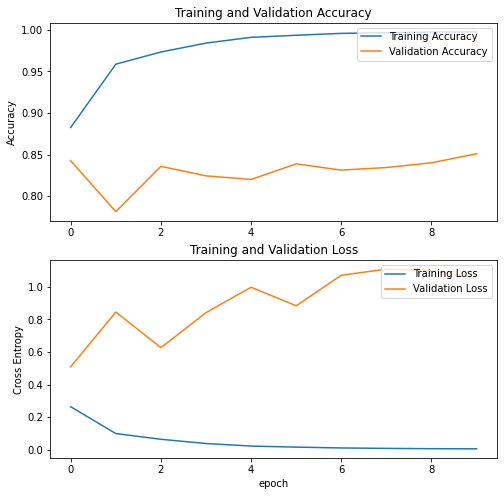

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [129]:
# for lyr in model.layers[-59:]:
#     lyr.trainable=True

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [41]:
history_fine = model.fit(train_ds,
                         epochs=15,
                         steps_per_epoch=40,
                         initial_epoch = history.epoch[-1]+1,
                         validation_data=test_ds,
                         validation_steps=4,
                         callbacks=[lrsc])


Epoch 00011: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 11/15
40/40 [==============================] - 11s 270ms/step - loss: 0.0054 - accuracy: 0.9977 - val_loss: 1.1139 - val_accuracy: 0.8488

Epoch 00012: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 12/15
40/40 [==============================] - 10s 245ms/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 1.0593 - val_accuracy: 0.8550

Epoch 00013: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 13/15
40/40 [==============================] - 10s 243ms/step - loss: 0.0042 - accuracy: 0.9980 - val_loss: 1.0917 - val_accuracy: 0.8555

Epoch 00014: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 14/15
40/40 [==============================] - 10s 243ms/step - loss: 0.0042 - accuracy: 0.9982 - val_loss: 1.1168 - val_accuracy: 0.8578

Epoch 00015: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.

In [42]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

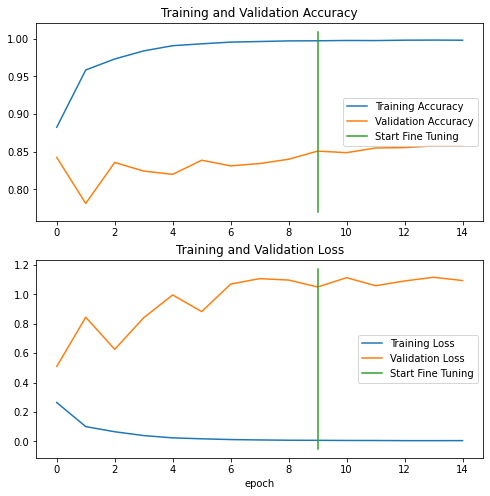

In [43]:
initial_epochs = history.epoch[-1]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs,initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='center right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
model.save("/content/drive/My Drive/new_model_0_75")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/new_model_0_75/assets


In [44]:
import os

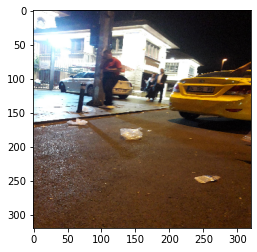

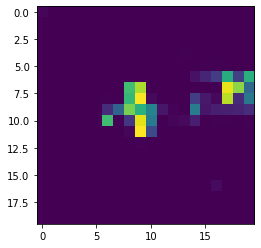

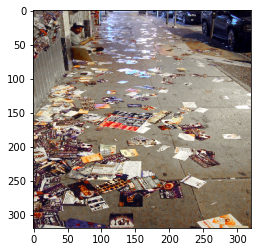

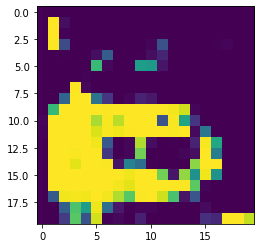

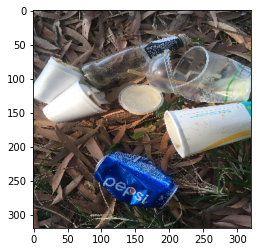

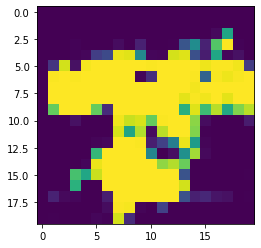

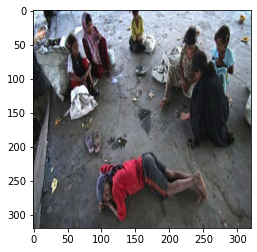

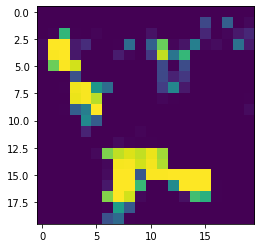

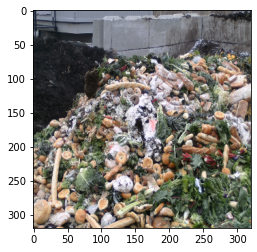

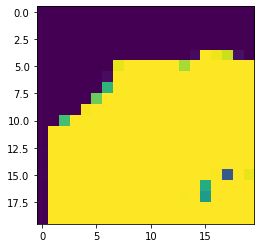

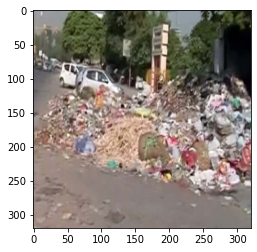

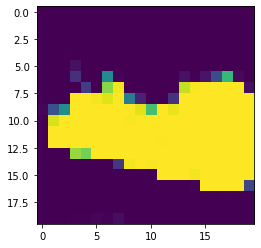

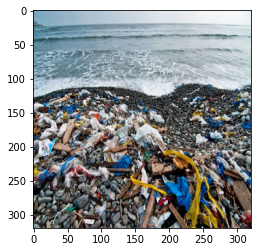

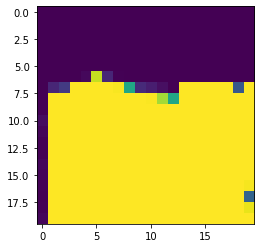

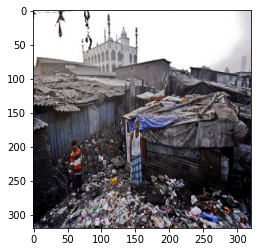

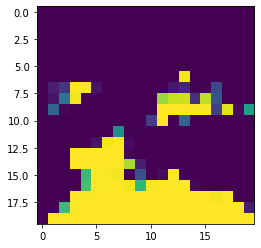

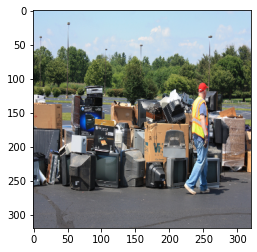

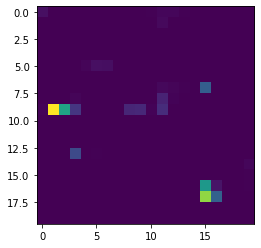

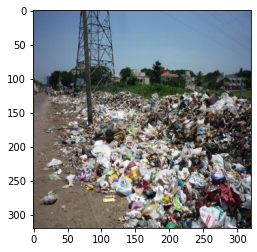

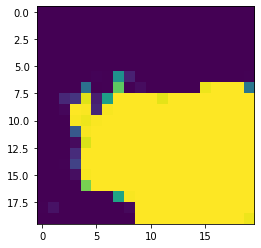

In [46]:
for fp in os.listdir("garbage_dataset/test/")[50:60]:
    img = cv2.imread("garbage_dataset/test/"+fp)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255
    pred = model.predict(np.expand_dims(img,0)).squeeze()
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    plt.imshow(img)
    plt.show()
    plt.imshow(pred)
    plt.show()